In [1]:
using Distributions
using Rocket
using ReactiveMP
using BenchmarkTools
using Plots

import ProgressMeter
using Random

import Base: show
import PDMats: PDMat

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1278
┌ Warning: Package ReactiveMP does not have Rocket in its dependencies:
│ - If you have ReactiveMP checked out for development and have
│   added Rocket as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ReactiveMP
└ Loading Rocket into ReactiveMP from project dependency, future warnings for ReactiveMP are suppressed.


In [297]:
function hgf_timeslice(model, zt_prev, xt_prev, z_covariance, y_covariance, kfunction)
    
    zcov = constvar(model, :zcov, z_covariance)
    zt   = randomvar(model, :zt)
    
    z_transition = make_node(model, MvNormalMeanCovariance, zt, zt_prev, zcov, factorisation = ((1, 2),(3,)))
    
    xt = randomvar(model, :xt)
    
    gcv = make_node(model, KernelGCV, KernelGCVMetadata(kfunction, ghcubature(2)), xt, xt_prev, zt)
    
    ycov = constvar(model, :ycov, y_covariance)
    y    = datavar(model, :y, Dirac{Vector{Float64}})
    
    obs = make_node(model, MvNormalMeanCovariance, y, xt, ycov)
    
    return (zt, xt, y, gcv, z_transition)
end

function hgf(n, iters, ndim, data, z_covariance, y_covariance, kfunction)
    model = Model(DefaultMessageGate())
    
    zs = Vector{RandomVariable}(undef, n)
    xs = Vector{RandomVariable}(undef, n)
    ys = Vector{DataVariable}(undef, n)
    
    zt_1_mean = datavar(model, :zt_1_mean, Dirac{Vector{Float64}})
    zt_1_cov  = datavar(model, :zt_1_cov, Dirac{PDMat{Float64, Matrix{Float64}}})
    zt_1      = randomvar(model, :zt_1)
    
    xt_1_mean = datavar(model, :xt_1_mean, Dirac{Vector{Float64}})
    xt_1_cov  = datavar(model, :xt_1_cov, Dirac{PDMat{Float64, Matrix{Float64}}})
    xt_1      = randomvar(model, :xt_1)
    
    zt_1_prior = make_node(model, MvNormalMeanCovariance, zt_1, zt_1_mean, zt_1_cov)
    xt_1_prior = make_node(model, MvNormalMeanCovariance, xt_1, xt_1_mean, xt_1_cov) 
    
    prev_zt_n = zt_1
    prev_xt_n = xt_1
    
    mz = Vector{MvNormalMeanCovariance}(undef, n)
    mx = Vector{MvNormalMeanCovariance}(undef, n)
    gcv = Vector{FactorNode}(undef, n)
    z_transition = Vector{FactorNode}(undef, n)
    
    mz_subs = Vector{Teardown}(undef, n)
    mx_subs = Vector{Teardown}(undef, n)
    
    ms_scheduler = PendingScheduler()

    for i in 1:n
        zt_n, xt_n, y_n, gcv_n, z_transition_n = hgf_timeslice(model, prev_zt_n, prev_xt_n, z_covariance, y_covariance, kfunction)
        
        zs[i] = zt_n
        xs[i] = xt_n
        ys[i] = y_n
        gcv[i] = gcv_n
        z_transition[i] = z_transition_n
        
        mz_subs[i] = subscribe!(getmarginal(zt_n) |> schedule_on(ms_scheduler), (t) -> mz[i] = getdata(t))
        mx_subs[i] = subscribe!(getmarginal(xt_n) |> schedule_on(ms_scheduler), (t) -> mx[i] = getdata(t))
    
        prev_zt_n = zt_n
        prev_xt_n = xt_n
    end
    
    activate!(model)
    
    foreach(gcv) do gcv_node
        setmarginal!(gcv_node, :y_x, MvNormalMeanCovariance(zeros(2 * ndim), PDMat(Matrix(Diagonal(10.0 * ones(2 * ndim))))))
        setmarginal!(gcv_node, :z, MvNormalMeanCovariance(zeros(ndim), PDMat(Matrix(Diagonal(10.0 * ones(ndim))))))
    end
    
    foreach(z_transition) do z_transition_node
        setmarginal!(z_transition_node, :out_mean, MvNormalMeanCovariance(zeros(2 * ndim), PDMat(Matrix(Diagonal(10.0 * ones(2 * ndim))))))
    end
    
    # Initial messages
    prior_zt = MvNormalMeanCovariance(zeros(ndim), PDMat(Matrix(Diagonal(1.0 * ones(ndim)))))
    prior_xt = MvNormalMeanCovariance(zeros(ndim), PDMat(Matrix(Diagonal(1.0 * ones(ndim)))))
    
    fe = Vector{Float64}()
    
    fe_scheduler = PendingScheduler()
    fe_sub = subscribe!(score(BetheFreeEnergy(), model, fe_scheduler), (d) -> push!(fe, d))
    
    ProgressMeter.@showprogress "inference" for _ in 1:iters
        
        update!(zt_1_mean, mean(prior_zt))
        update!(zt_1_cov, cov(prior_zt))
        update!(xt_1_mean, mean(prior_xt))
        update!(xt_1_cov, cov(prior_xt))
        
        for i in 1:n
            update!(ys[i], data[i])
        end
        
        release!(fe_scheduler)
    end
    
    release!(ms_scheduler)
 
    foreach(unsubscribe!, mz_subs)
    foreach(unsubscribe!, mx_subs)
    unsubscribe!(fe_sub)
    
    return mz, mx, fe
end

hgf (generic function with 1 method)

In [298]:
import ReactiveMP: @rule, @marginalrule, score

using PDMats

import ForneyLab

@rule(
    form => Type{ <: MvNormalMeanCovariance },
    on   => :mean,
    vconstraint => Marginalisation,
    messages => (m_out::ReactiveMP.FnWithApproximation, ),
    marginals => (q_covariance::Dirac, ),
    meta => Nothing,
    begin
        vindex = ReactiveMP.varindex(__node, :mean)
        vin    = @inbounds ReactiveMP.variables(__node)[vindex]
        return vin.m_in |> take(1) |> map(MvNormalMeanCovariance, (m_mean) -> begin
            msg_fwd = MvNormalMeanCovariance(mean(m_mean), cov(m_mean) + mean(q_covariance))
            multiplication = getdata(as_message(msg_fwd) * as_message(m_out))
            
            m, c = mean(multiplication), cov(multiplication)
            return MvNormalMeanCovariance(m, c + mean(q_covariance))
        end)
    end
)

@marginalrule(
    form => Type{ <: MvNormalMeanCovariance },
    on   => :out_mean,
    messages => (m_out::MvNormalMeanCovariance, m_mean::MvNormalMeanCovariance),
    marginals => (q_covariance::Dirac, ),
    meta => Nothing,
    begin
        W_y  = inv(cov(m_out))
        xi_y = W_y * mean(m_out)

        W_m  = inv(cov(m_mean))
        xi_m = W_m * mean(m_mean)

        W_bar = mean(q_covariance)
        
        xi = [ xi_y; xi_m ]
        W  = PDMat(Matrix(Hermitian([ W_y+W_bar -W_bar; -W_bar W_m+W_bar ])))
        
        m = inv(W) * xi
        c = inv(W)
        
        return MvNormalMeanCovariance(m, c)
    end
)

@marginalrule(
    form => Type{ <: MvNormalMeanCovariance },
    on   => :out_mean,
    messages => (m_out::ReactiveMP.FnWithApproximation, m_mean::MvNormalMeanCovariance),
    marginals => (q_covariance::Dirac, ),
    meta => Nothing,
    begin
        d = ndims(m_mean)
        
        m_mean_mean, m_mean_cov = mean(m_mean), cov(m_mean)
        
        Wbar = mean(q_covariance)
        
        W = [ Wbar -Wbar; -Wbar Wbar ]

        logpdf = getdata(m_out).fn

        msg_fwd = MvNormalMeanCovariance(mean(m_mean), cov(m_mean) + mean(q_covariance))
        v_mean_inv = inv(m_mean_cov)

        l(z) = @views -0.5 * z'*W*z - 0.5 * (z[d+1:end] - m_mean_mean)' * v_mean_inv * (z[d+1:end] - m_mean_mean) + logpdf(z[1:d])

        #Expansion point
        point1 = mean(as_message(msg_fwd) * as_message(m_out))

        try
            # @show point1
            m_joint, v_joint = ForneyLab.NewtonMethod(l, [ point1; m_mean_mean ])
            return MvNormalMeanCovariance(m_joint, PDMat(Matrix(Hermitian(v_joint))))
        catch e
            # println("fallback")
            println(e)
            error("fallback")
            # Use cubature as a fallback
            # cubature  = msg_out.dist.params[:cubature]
            # mean, cov = approximate_meancov(cubature, (x) -> exp(logpdf(x)), msg_fwd.dist)

            # approx_message = Message(Multivariate, GaussianMeanVariance, m = mean, v = cov)
            # return ruleMGaussianMeanPrecisionGGD(approx_message, msg_mean, dist_prec)
        end
    end
)

@marginalrule(
    form => Type{ <: MvNormalMeanCovariance },
    on   => :out_mean_covariance,
    messages => (m_out::MvNormalMeanCovariance, m_mean::Dirac, m_covariance::Dirac),
    marginals => Nothing,
    meta => Nothing,
    begin
        q_out = m_out * as_message(MvNormalMeanCovariance(mean(m_mean), mean(m_covariance)))
        return (getdata(q_out), getdata(m_mean), getdata(m_covariance))
    end
)

@marginalrule(
    form => Type{ <: MvNormalMeanCovariance },
    on   => :out_mean_covariance,
    messages => (m_out::Dirac, m_mean::MvNormalMeanCovariance, m_covariance::Dirac),
    marginals => Nothing,
    meta => Nothing,
    begin
        q_mean = m_mean * as_message(MvNormalMeanCovariance(mean(m_out), mean(m_covariance)))
        return (getdata(m_out), getdata(q_mean), getdata(m_covariance))
    end
)

function ReactiveMP.score(::AverageEnergy, ::Type{ <: MvNormalMeanCovariance }, marginals::Tuple{ <: Marginal,  <: Marginal, <: Marginal }, ::Nothing)
    marg_mean = marginals[2]
    marg_out = marginals[1]
    marg_var = marginals[3]
    
    (m_mean, v_mean) = mean(marg_mean), cov(marg_mean)
    (m_out, v_out) = mean(marg_out), cov(marg_out)

    0.5*ndims(marg_out)*log(2*pi) +
    0.5*logdet(mean(marg_var)) +
    0.5*tr(inv(mean(marg_var))*(v_out + v_mean + (m_out - m_mean)*(m_out - m_mean)'))
end

function ReactiveMP.score(::AverageEnergy, ::Type{ <: MvNormalMeanCovariance }, marginals::Tuple{ <: Marginal, <: Marginal }, ::Nothing)
    marg_out_mean = marginals[1]
    marg_var = marginals[2]
    
    (m, V) = mean(marg_out_mean), cov(marg_out_mean)
    d = Int64(ndims(marg_out_mean)/2)

    0.5*d*log(2*pi) +
    0.5*log(det(mean(marg_var))) +
    0.5*tr( inv(mean(marg_var))*( V[1:d,1:d] - V[1:d,d+1:end] - V[d+1:end,1:d] + V[d+1:end,d+1:end] + (m[1:d] - m[d+1:end])*(m[1:d] - m[d+1:end])' ) )
end

function ReactiveMP.score(::AverageEnergy, ::Type{ <: KernelGCV }, marginals::Tuple{ <: Marginal{ <: MvNormalMeanCovariance }, <: Marginal{ <: MvNormalMeanCovariance } }, meta::KernelGCVMetadata)
    marg_out_mean = marginals[1]
    marg_z = marginals[2]
    
    (m, V) = mean(marg_out_mean), cov(marg_out_mean)
    (mz,Vz) = mean(marg_z), cov(marg_z)

    d = Int64(ndims(marg_out_mean) / 2)

    cubature = ReactiveMP.get_approximation(meta)
    weights = ReactiveMP.getweights(cubature, mz, Vz)
    points  = ReactiveMP.getpoints(cubature, mz, Vz)
    
    kernelfn = ReactiveMP.get_kernelfn(meta)

    gs = Base.Generator(points) do point
        return kernelfn(point)
    end

    Λ_out = mapreduce(t -> t[1] * inv(t[2]), +, zip(weights, gs))
    log_det_sum = mapreduce(t -> t[1] * log(det(t[2])), +, zip(weights, gs))

    @views 0.5*d*log(2*pi) +
    0.5*log_det_sum +
    0.5*tr( Λ_out*( V[1:d,1:d] - V[1:d,d+1:end] - V[d+1:end,1:d] + V[d+1:end,d+1:end] + (m[1:d] - m[d+1:end])*(m[1:d] - m[d+1:end])' ) )
end

function ReactiveMP.score(::DifferentialEntropy, ::Marginal{ <: Dirac })
    return 0.0
end

In [299]:
using KernelFunctions
# import ForneyLab: softmax

gkernel = TransformedKernel(Matern32Kernel(),FunctionTransform(x -> sin.(x)));
skernel = SqExponentialKernel()

Squared Exponential Kernel

In [383]:
using Random
using Distributions
using LinearAlgebra

n = 500
iters = 10
ndim = 4

# Random.seed!(226)
Random.seed!(223)

real_k = ones(ndim)
real_w = [ -2.0, -1.0, -3.0, -1.5 ]

# kfunction = (d) -> kernelmatrix(gkernel, d) .+ Diagonal(exp.(real_k .* d .+ real_w))
kfunction = (d) -> Diagonal(exp.(real_k .* d .+ real_w))
# kfunction = (d) -> Matrix(Hermitian(Diagonal(real_k .* exp.(d) .+ real_w)))
# kfunction = (d) -> kernelmatrix(gkernel, d) + Diagonal([ 1.0, 1.0 ])
# kfunction = (d) -> kernelmatrix(skernel, d) + Diagonal([ 1.0, 1.0 ])

z_prev       = 2.0 * ones(ndim)
z_covariance = PDMat(Matrix(Diagonal(0.01 * ones(ndim))))

z = Vector{Vector{Float64}}(undef, n)
for i in 1:n
    z[i] = rand(MvNormal(z_prev, sqrt(Matrix(z_covariance))))
    z_prev = z[i]
end

# z = map(d -> 2.0 * sin(0.005 * d), 1:n)

v = map(d -> kfunction(d), z)

x_prev = zeros(ndim)

x = Vector{Vector{Float64}}(undef, n)

for i in 1:n
    x[i] = rand(MvNormal(x_prev, sqrt(v[i])))
    x_prev = x[i]
end

y = Vector{Vector{Float64}}(undef, n)
y_covariance = PDMat(Matrix(Diagonal(1.0 * ones(ndim))))

for i in 1:n
    y[i] = rand(MvNormal(x[i], sqrt(Matrix(y_covariance))))
end

In [384]:
@time mz, mx, fe = hgf(n, iters, ndim, y, z_covariance, y_covariance, kfunction); # Initial compilation

inference100%|██████████████████████████████████████████| Time: 0:00:10


 11.218066 seconds (56.15 M allocations: 3.030 GiB, 9.92% gc time)


In [385]:
# @time mz, mx = hgf(n, iters, ndim, y, z_covariance, y_covariance, kfunction); # Subsequent runs

In [386]:
function plot_dimension(mz, mx, dim = 1)
    plot(map(d -> d[dim], mean.(mz)), ribbon = map(d -> sqrt(d[dim]), var.(mz)), label = :z)
    p1 = plot!(map(d -> d[dim], z), label = :real_z)

    plot(map(d -> d[dim], mean.(mx)), ribbon = map(d -> sqrt(d[dim]), var.(mx)), label = :x)
    p2 = plot!(map(d -> d[dim], x), label = :real_x)

    plot(p1, p2, layout = (2, 1), size = (800, 600))
end

plot_dimension (generic function with 2 methods)

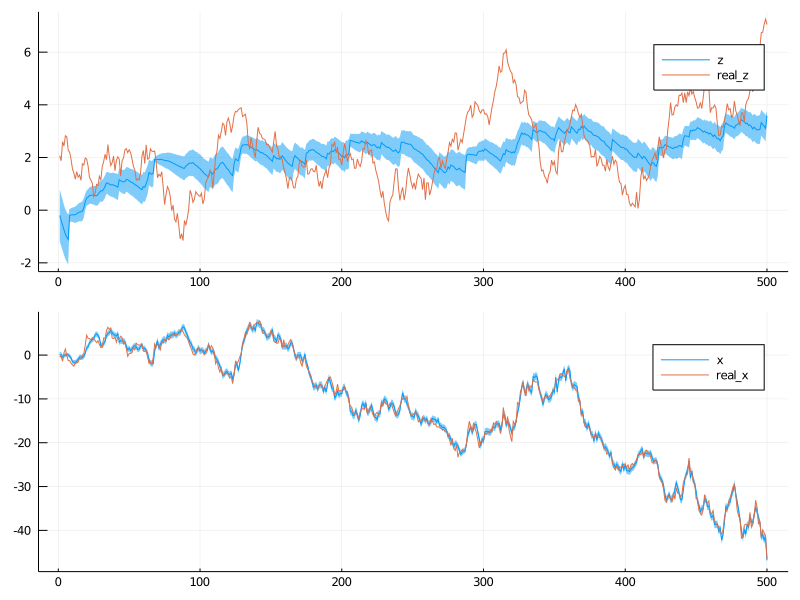

In [392]:
plot_dimension(mz, mx, 1)

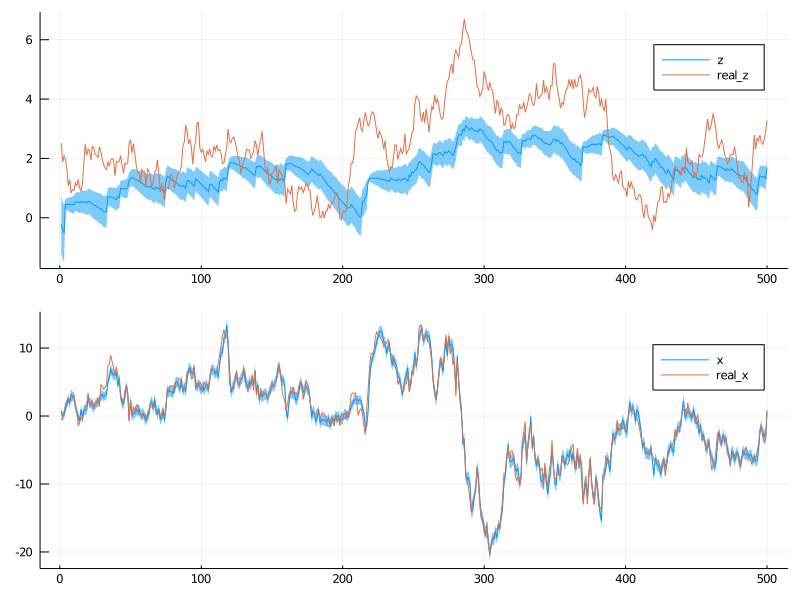

In [393]:
plot_dimension(mz, mx, 2)

In [389]:
# plot(map(e -> e.values[1], eigen.(v)), label = :eigen1)
# p1 = plot!(map(z -> eigen(kfunction(z)).values[1], mean.(mz)), label = :z1)

# plot(map(e -> e.values[2], eigen.(v)), label = :eigen2)
# p2 = plot!(map(z -> eigen(kfunction(z)).values[2], mean.(mz)), label = :z2)

# plot(p1, p2, size = (1000, 600), layout = (2, 1))

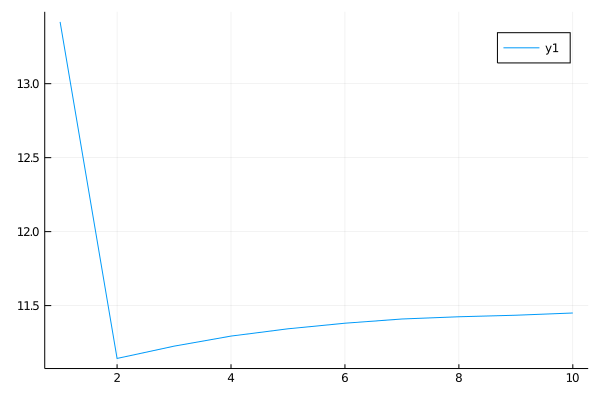

In [390]:
plot(log.(fe[1:end]))

In [391]:
log.(fe[1:end])

10-element Array{Float64,1}:
 13.417582475699902
 11.142824166067049
 11.22585388172617
 11.2939653589377
 11.343181981468009
 11.380974886130797
 11.409406046648979
 11.424553526704905
 11.434914466908557
 11.449962176816536